# NYC Public High School Success Classification Project 

## Step 1:  Import all the libaries we need

In [13]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 200
pd.options.display.max_rows = 999
import matplotlib.pyplot as plt  

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
import pandas as pd
import numpy as np
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC  
from time import time
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


## Step 2:  Get NYC HS graduation outcomes - we will use three years (2015, 2016, 2017)

In [14]:
df = pd.read_csv('data/2016-2017_Graduation_Outcomes_School.csv')

### Pull out only those rows for high schools for cohorts 2011 (graduating 2015), 2012 (graduating 2016), and 2013 (graduating 2017), and create new IDs comprising the high school "DBN" ID with the graduation year.

In [17]:
# get 2014 graduation (2010 cohort)
df_2014 = df[df['Cohort Year'] == '2,010'][df.Cohort=='4 year June'][df['Demographic Category']=='All Students']

# create a new column (will become the index) combining DBN ID + grad year
df_2014['ID'] = df_2014.DBN + '_' + '2014'

In [18]:
# get 2015 graduation (2011 cohort)
df_2015 = df[df['Cohort Year'] == '2,011'][df.Cohort=='4 year June'][df['Demographic Category']=='All Students']

# create a new column (will become the index) combining DBN ID + grad year
df_2015['ID'] = df_2015.DBN + '_' + '2015'

In [19]:
# get 2016 graduation (2012 cohort)
df_2016 = df[df['Cohort Year'] == '2,012'][df.Cohort=='4 year June'][df['Demographic Category']=='All Students']

# create a new column (will become the index) combining DBN ID + grad year
df_2016['ID'] = df_2016.DBN + '_' + '2016'

In [20]:
# get 2017 graduation (2012 cohort)
df_2017 = df[df['Cohort Year'] == '2,013'][df.Cohort=='4 year June'][df['Demographic Category']=='All Students']

# create a new column (will become the index) combining DBN ID + grad year
df_2017['ID'] = df_2017.DBN + '_' + '2017'

### Create three dataframes to stage our three graduation years

In [21]:
df_2015_target = df_2015[['ID', 'School Name', 'Total Grads % of cohort']]

In [22]:
df_2016_target = df_2016[['ID', 'School Name', 'Total Grads % of cohort']]

In [23]:
df_2017_target = df_2017[['ID', 'School Name', 'Total Grads % of cohort']]

### Now concatenate them into a single dataframe of graduation "targets" (our labels)

In [24]:
df_hs_target = pd.concat([df_2015_target, df_2016_target, df_2017_target])

### Save our target data

In [26]:
df_hs_target.to_csv('data/df_hs_target.csv')

In [27]:
df_qual_2014_15 = pd.read_csv('data/2014-2015_School_Quality_Results_for_High_Schools.csv')
df_qual_2014_15['ID'] = df_qual_2014_15['DBN'] + '_' + '2015'

In [30]:
df_qual_2015_16 = pd.read_csv('data/2015_-_2016_School_Quality_Report_Results_for_High_School.csv')
df_qual_2015_16['ID'] = df_qual_2015_16['DBN'] + '_' + '2016'

In [31]:
df_qual_2016_17 = pd.read_csv('data/2016_-_2017_School_Quality_Report_Results_for_High_Schools.csv')
df_qual_2016_17['ID'] = df_qual_2016_17['DBN'] + '_' + '2017'

In [32]:
df_qual = pd.concat([df_qual_2014_15, df_qual_2015_16, df_qual_2016_17], sort=True)

In [42]:
## Some EDA
df_qual['Percent of Students Chronically Absent'].count()
df_qual['Percent in Temp Housing'].count()

978

In [43]:
target_ids = df_hs_target['ID']

In [44]:
len(target_ids)

1418

In [49]:
qual_ids = df_qual['ID']

In [50]:
len(qual_ids)

1470

In [52]:
missing_ids = []
qual_id_list = qual_ids
target_id_list = target_ids

In [53]:
for i in range(len(qual_id_list)):
    if qual_id_list[i] not in target_id_list:
        missing_ids.append(qual_id_list[i])

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:
len(missing_ids)

In [ ]:
missing_ids

In [55]:
df_qual[df_qual.ID =='08X558_2015']

,Average Grade 8 English Proficiency,Average Grade 8 Math Proficiency,Collaborative Teachers - Percent Positive,Collaborative Teachers Rating,DBN,Economic Need Index,Effective School Leadership - Percent Positive,Effective School Leadership Rating,Enrollment,ID,Percent Asian,Percent Black,Percent English Language Learners,Percent HRA Eligible,Percent Hispanic,Percent Overage/ Undercredited,Percent Overage/Undercredited,Percent Self-Contained,Percent Students with Disabilities,Percent White,Percent in Temp Housing,Percent in Temp Housing - 4yr,Percent of Students Chronically Absent,Percent of teachers with 3 or more years of experience,Quality Review - Dates of Review,Quality Review - How clearly are high expectations communicated to students and staff?,Quality Review - How effective is the teaching and learning?,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How safe and inclusive is the school while supporting social-emotional growth?,Quality Review - How thoughtful is the school’s approach to teacher development and evaluation?,Quality Review - How well are school decisions evaluated and adjusted?,Quality Review - How well do teachers work with each other?,Quality Review - How well does the school allocate and manage resources?,Quality Review - How well does the school assess what students are learning?,"Quality Review - How well does the school identify, track, and meet its goals?",Rigorous Instruction - Percent Positive,Rigorous Instruction Rating,School Name,School Type,Strong Family-Community Ties - Percent Positive,Strong Family-Community Ties Rating,Student Achievement Rating,Student Attendance Rate,Supportive Environment - Percent Positive,Supportive Environment Rating,Teacher Attendance Rate,Trust - Percent Positive,Trust Rating,Years of principal experience at this school
142,2.37,2.19,93%,NaN,08X558,70.10%,94%,NaN,396,08X558_2015,4.50%,26.80%,6.80%,55.30%,56.60%,NaN,NaN,1.30%,22.50%,8.80%,NaN,9.30%,42.30%,32.30%,10-Dec-14,Proficient,Proficient,Proficient,NaN,NaN,NaN,Proficient,NaN,Well Developed,NaN,87%,NaN,Westchester Square Academy,High School,78%,NaN,NaN,86.50%,84%,NaN,97.30%,93%,NaN,3.0


In [56]:
df_hs_target[df_hs_target.ID =='08X558_2015']

,ID,School Name,Total Grads % of cohort


In [54]:
df_qual[df_qual.ID=='05M157_2015'].index

Int64Index([88], dtype='int64')

In [57]:
df_qual.drop(df_qual.loc[df_qual['ID']=='05M157_2015'].index, inplace=True)

In [58]:
len(df_qual)

1467

In [ ]:
# for i in missing_ids:
#     df_qual.drop(df_qual.loc[df_qual['ID']==i].index, inplace=True)

In [ ]:
df_qual.head()

In [ ]:
df_hs_target.head()

In [ ]:
len(df_hs_target)

In [ ]:
len(df_qual)

In [ ]:
# df_merged = pd.concat([df_qual, df_hs_target],axis=1, join='inner', keys=['ID'])

## Step 3:  Merge targets and features

In [59]:
df_merged = pd.merge(left=df_hs_target, right=df_qual, how='inner', on='ID' )

In [60]:
df_merged.columns.values


array(['ID', 'School Name_x', 'Total Grads % of cohort',
       'Average Grade 8 English Proficiency',
       'Average Grade 8 Math Proficiency',
       'Collaborative Teachers - Percent Positive',
       'Collaborative Teachers Rating', 'DBN', 'Economic Need Index',
       'Effective School Leadership - Percent Positive',
       'Effective School Leadership Rating', 'Enrollment',
       'Percent Asian', 'Percent Black',
       'Percent English Language Learners', 'Percent HRA Eligible',
       'Percent Hispanic', 'Percent Overage/ Undercredited',
       'Percent Overage/Undercredited', 'Percent Self-Contained',
       'Percent Students with Disabilities', 'Percent White',
       'Percent in Temp Housing', 'Percent in Temp Housing - 4yr',
       'Percent of Students Chronically Absent',
       'Percent of teachers with 3 or more years of experience',
       'Quality Review - Dates of Review',
       'Quality Review - How clearly are high expectations communicated to students and staff?

### Save our merged dataframe

In [62]:
df_merged.to_csv('data/features_and_targets.csv')

In [83]:
df_merged = pd.read_csv('data/features_and_targets.csv')

In [84]:
len(df_merged.columns)

52

In [65]:
# df_merged.isna()

In [68]:
# df_merged['Percent Overage/ Undercredited']

### Do some more cleanup - drop unneeded columns/features

In [85]:
# Denote the column names to drop
drop_columns = ['Percent Overage/Undercredited',
                'Percent Overage/ Undercredited',
                'School Name_y',
                'School Type',
                'Quality Review - How well does the school identify, track, and meet its goals?',
                'Quality Review - How safe and inclusive is the school while supporting social-emotional growth?',
                'Quality Review - How thoughtful is the school’s approach to teacher development and evaluation?',
                'Quality Review - How well are school decisions evaluated and adjusted?',
                'Quality Review - How well does the school allocate and manage resources?',
                'DBN',
                'Quality Review - Dates of Review'                 
               ]

# Drop all of the columns!
df_merged.drop(columns=drop_columns, inplace=True)

### This is an important step:  we need to rationalize our temp housing data, which is spread across two different columns

In [89]:
##
## Important code combines temp housing stats
## which are split across two different columns
##
df_merged['Percent in Temp Housing - 4yr'] = np.where(df_merged['Percent in Temp Housing - 4yr'].isna(), df_merged['Percent in Temp Housing'],df_merged['Percent in Temp Housing - 4yr'])
df_merged['Percent in Temp Housing'] = np.where(df_merged['Percent in Temp Housing'].isna(), df_merged['Percent in Temp Housing - 4yr'],df_merged['Percent in Temp Housing'])

### We now label-encode our categorical data

In [92]:
##
## Category Label Encoding
##
categories_1 = ['Not Meeting Target', 'Approaching Target', 'Meeting Target', 'Exceeding Target']
categories_2 = ['Under Developed', 'Developing', 'Proficient', 'Well Developed']
cat_1_cols = ['Collaborative Teachers Rating', 
              'Effective School Leadership Rating', 
              'Rigorous Instruction Rating',
              'Strong Family-Community Ties Rating',
              'Student Achievement Rating',
              'Supportive Environment Rating',
              'Trust Rating']
cat_2_cols = ['Quality Review - How clearly are high expectations communicated to students and staff?', 
              'Quality Review - How effective is the teaching and learning?',
              'Quality Review - How interesting and challenging is the curriculum?',
              'Quality Review - How well do teachers work with each other?',
              'Quality Review - How well does the school assess what students are learning?']

In [93]:
##
## Create category transformer dicts for each of our two
## sets of column categories; and add zero values since
## we will fillna() with zeros
##
cat_1_transform_dict = {k:v for v, k in enumerate(categories_1, start=1)}
cat_1_transform_dict.update({0:0})
cat_2_transform_dict = {k:v for v, k in enumerate(categories_2, start=1)}
cat_2_transform_dict.update({0:0})

In [ ]:
#df_merged['Collaborative Teachers Rating'] = cat_1_transform_dict[df_merged['Collaborative Teachers Rating']]

In [94]:
df_merged['Collaborative Teachers Rating'].fillna(value=0, inplace=True)

In [95]:
df_merged['Collaborative Teachers Rating'] = df_merged['Collaborative Teachers Rating'].apply(lambda x: cat_1_transform_dict[x])

In [97]:
##
## Important code:  fillna() for our category
## columns
##
for col in cat_1_cols:
    df_merged[col].fillna(value=0, inplace=True)

for col in cat_2_cols:
    df_merged[col].fillna(value=0, inplace=True)

In [98]:
cat_1_cols

['Collaborative Teachers Rating',
 'Effective School Leadership Rating',
 'Rigorous Instruction Rating',
 'Strong Family-Community Ties Rating',
 'Student Achievement Rating',
 'Supportive Environment Rating',
 'Trust Rating']

In [99]:
cat_1_transform_dict

{'Not Meeting Target': 1,
 'Approaching Target': 2,
 'Meeting Target': 3,
 'Exceeding Target': 4,
 0: 0}

In [103]:
##
## Now apply the transformations
##
for col in cat_1_cols:
    df_merged[col] = df_merged[col].apply(lambda x: cat_1_transform_dict[x])
    
for col in cat_2_cols:
    df_merged[col] = df_merged[col].apply(lambda x: cat_2_transform_dict[x])    

In [105]:
df_merged.Enrollment.fillna(value=0, inplace=True)

In [ ]:
df_merged.Enrollment.dtype

In [ ]:
# df_merged.Enrollment = df_merged.Enrollment.str.replace(',', ''

In [106]:
df_merged['Collaborative Teachers - Percent Positive'] = df_merged['Collaborative Teachers - Percent Positive'].str.replace('%','')

In [107]:
df_merged.astype({'Collaborative Teachers - Percent Positive': float}).dtypes

Unnamed: 0                                                                                  int64
ID                                                                                         object
School Name_x                                                                              object
Total Grads % of cohort                                                                   float64
Average Grade 8 English Proficiency                                                       float64
Average Grade 8 Math Proficiency                                                          float64
Collaborative Teachers - Percent Positive                                                 float64
Collaborative Teachers Rating                                                               int64
Economic Need Index                                                                        object
Effective School Leadership - Percent Positive                                             object
Effective School Lea

In [ ]:
df.columns

In [110]:
df_merged['Percent Asian'].dtype

dtype('O')

In [109]:
object_types = []
for i in list(df_merged.columns):
    print(df_merged[i].dtype)
    if df_merged[i].dtype == 'object':
        object_types.append(i)

int64
object
object
float64
float64
float64
object
int64
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
object
float64


In [112]:
object_types

['ID',
 'School Name_x',
 'Collaborative Teachers - Percent Positive',
 'Economic Need Index',
 'Effective School Leadership - Percent Positive',
 'Effective School Leadership Rating',
 'Enrollment',
 'Percent Asian',
 'Percent Black',
 'Percent English Language Learners',
 'Percent HRA Eligible',
 'Percent Hispanic',
 'Percent Self-Contained',
 'Percent Students with Disabilities',
 'Percent White',
 'Percent in Temp Housing',
 'Percent in Temp Housing - 4yr',
 'Percent of Students Chronically Absent',
 'Percent of teachers with 3 or more years of experience',
 'Quality Review - How clearly are high expectations communicated to students and staff?',
 'Quality Review - How effective is the teaching and learning?',
 'Quality Review - How interesting and challenging is the curriculum?',
 'Quality Review - How well do teachers work with each other?',
 'Quality Review - How well does the school assess what students are learning?',
 'Rigorous Instruction - Percent Positive',
 'Rigorous Inst

In [114]:
# 
# Remove the two types we do NOT
# want to convert to floats:  ID and Name
# object_types.pop(0)
#
object_types.pop(0)

'School Name_x'

In [115]:
##
## Important code:  clean up the columns
## denoted in the "object_types" list of columns:
## - fillna with zeros - reasonable;
## - remove the "%"
## - convert to float
##
for col in object_types:
    df_merged[col].fillna(value=0, inplace=True)
    df_merged[col] = df_merged[col].str.replace('%','')    
    df_merged[col] = df_merged[col].astype(float)

ValueError: could not convert string to float: 'Approaching Target'

In [ ]:
df_merged.head()

In [34]:
##
## Data is pretty clean, so SAVE IT!
##
df_merged.to_csv('data/clean_target_feature_data.csv')

In [45]:
df_merged = pd.read_csv('data/clean_target_and_features.csv')

In [46]:
len(df_merged)

1225

In [ ]:
len(df_merged.columns)

In [ ]:
len(df_merged)

In [24]:
df_merged = pd.read_csv('data/class_labels_and_targets.csv')

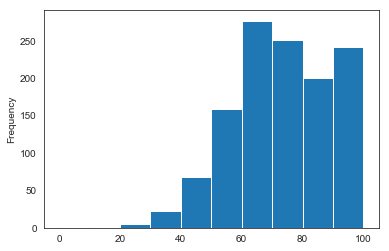

In [47]:
df_merged['Total Grads % of cohort'].plot(kind='hist')

In [39]:
df_merged['Total Grads % of cohort'].describe()

count    1225.000000
mean       73.409143
std        16.270372
min         0.000000
25%        62.000000
50%        72.900000
75%        87.400000
max       100.000000
Name: Total Grads % of cohort, dtype: float64

In [ ]:
##
## Do some visualization
##

In [48]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

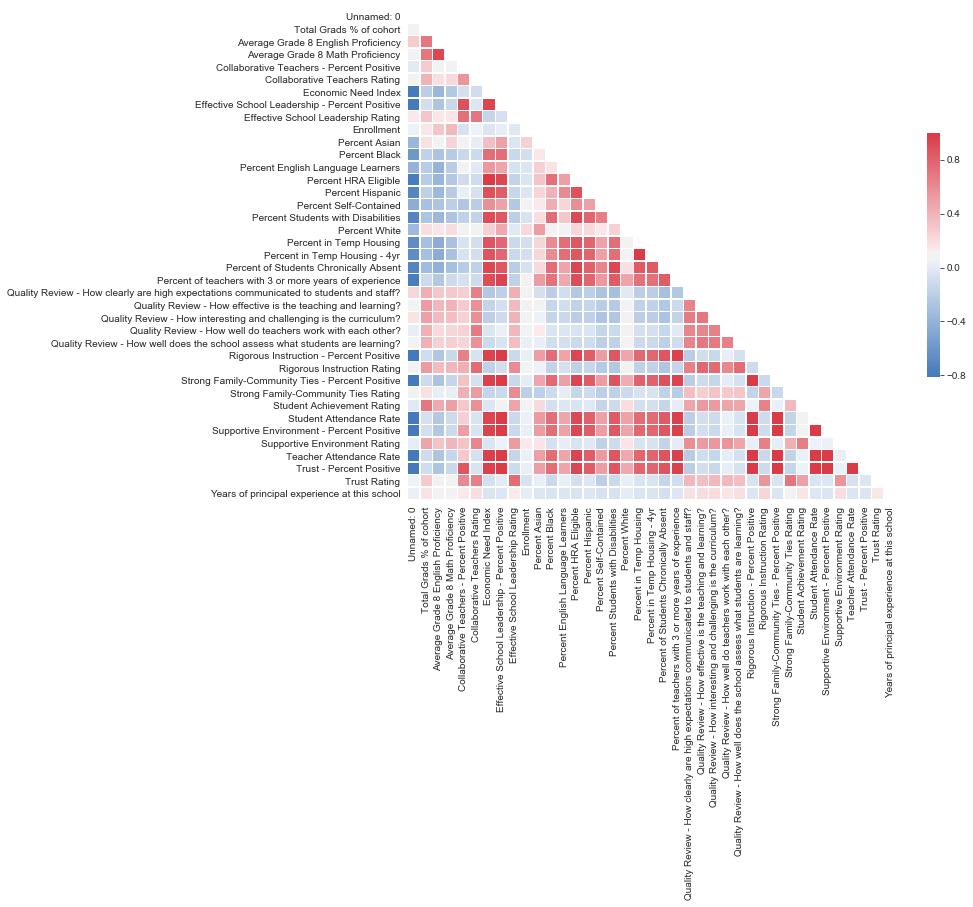

In [49]:
# run a correlation on all of our variables
# print the heat map 
import seaborn as sns
corr = df_merged.corr()
CorrMtx(corr, dropDuplicates = True)

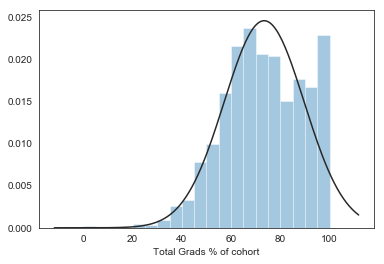

<Figure size 432x288 with 0 Axes>

In [139]:
import scipy.stats as stats
sns.distplot(df_merged['Total Grads % of cohort'], fit=stats.norm, bins=20, kde=False);

plt.savefig('plots/target_dist.png')
plt.show()
fig = plt.figure()


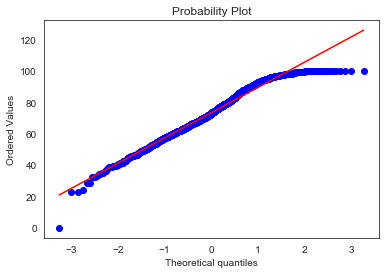

In [51]:
res = stats.probplot(df_merged['Total Grads % of cohort'], plot=plt)
plt.show()
#plt.savefig('plots/target_prob.png')

In [ ]:
df_merged['Total Grads % of cohort'].describe()

In [ ]:
bad_labels = df_merged[df_merged['Total Grads % of cohort'].isna()]['ID'].index

In [ ]:
##
## Save our dataframe again!
##
df_merged.to_csv('data/clean_target_and_features.csv')

In [ ]:
df_1 = df_merged[df_merged['Total Grads % of cohort'] > 73]

In [ ]:
len(df_1)

In [ ]:
len(df_merged)

In [ ]:
df_merged.median()

In [ ]:
len(bad_labels)

In [55]:
features = list(df_merged.columns.values)

In [ ]:
len(features)

In [63]:
#break the colums into groups to plot 4 on a row at a time
n = 4
row_groups= [features[i:i+n] for i in range(0, len(features), n) ]

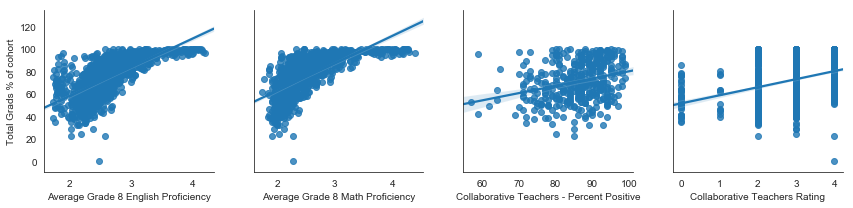

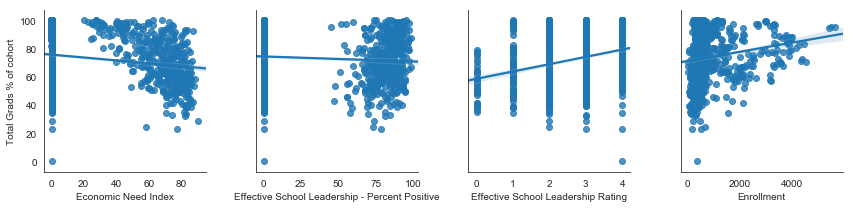

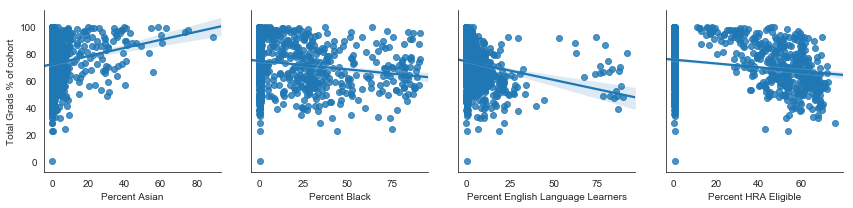

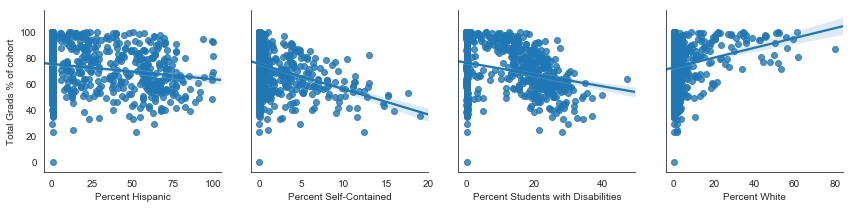

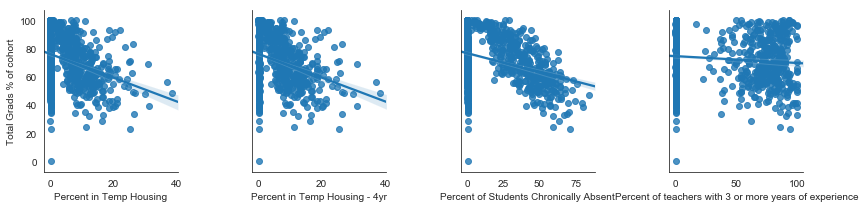

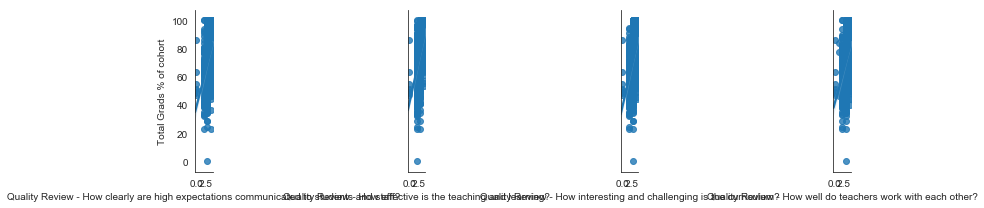

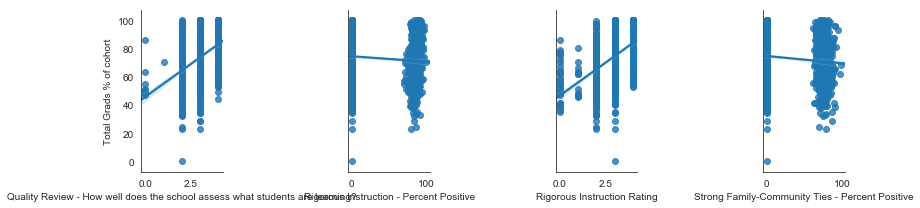

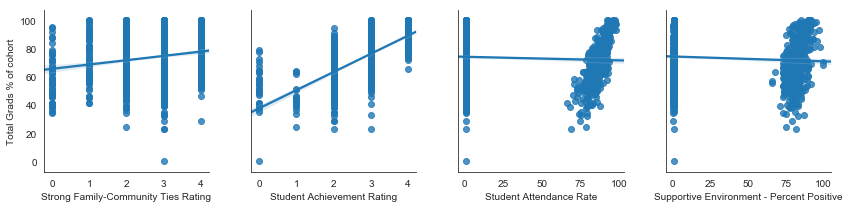

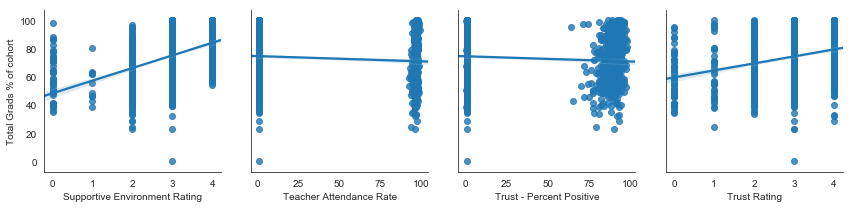

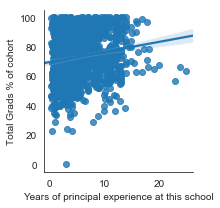

In [64]:
# create scatter plots for every independent variable vs. our target variable
for i in row_groups:
    pp = sns.pairplot(data=df_merged, y_vars=['Total Grads % of cohort'],x_vars=i, kind="reg", height=3)

In [ ]:
plot = sns.pairplot(data=df_merged, y_vars=['savePctg'],
             x_vars='shotsFor', kind="reg", 
             height=4,aspect=1.5)
plot.fig.suptitle('Correlation between save percentage and win percentage')
# plot.axes.set_xlabel('Number of faceoffs lost in a season')
plt.xlabel("Goalie's save percentage")
plt.ylabel('Win percentage')

plot.savefig('Corr4.png')

In [65]:
df_merged['target'] = np.where(df_merged['Total Grads % of cohort'] > 73, 1, 0)

In [66]:
x_class_pass = df_merged[df_merged.target==1]['target']

In [67]:
x_class_fail = df_merged[df_merged.target==0]['target']

In [74]:
len(x_class_fail)

614

In [75]:
len(x_class_pass)

611

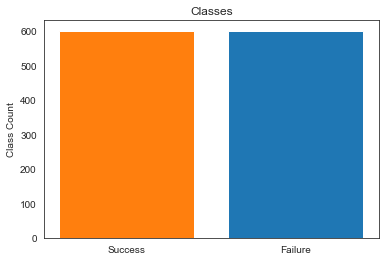

In [138]:
# plt.bar(x_class_pass, len(x_class_pass))
# plt.xticks(x_class_pass, ('Success'))
# plt.bar(x_class_fail, len(x_class_fail))
# plt.xticks(x_class_fail, ('Fail'))
# plt.xlabel('HS Succes|Fail Classes')
# plt.ylabel('Class Count')
# plt.title('HS Succes|Fail Classes')
# plt.show()

###

labels = ['Success', 'Failure']


x = np.arange(len(labels))  # the label locations
width = 0.50  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x_class_pass, height=600, label='Success')
ax.bar(x_class_fail, height=600, label='Failure')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Class Count')
ax.set_title('Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)


plt.savefig('plots/class_count.png')

plt.show()


In [83]:
df_merged.to_csv('data/class_labels_and_targets.csv')

In [ ]:
scatter_matrix(df_merged[features], figsize=(12, 8))

In [ ]:
df_merged.hist(bins=50, figsize=(20,15))

In [ ]:
len(df_merged.columns)

In [81]:
Y_all = df_merged['target']

In [ ]:
len(Y_all)

In [ ]:
df_merged.columns

In [82]:
X_all = df_merged.drop(['target','Total Grads % of cohort', 'Unnamed: 0'], axis=1).copy()

In [ ]:
len(X_all.columns)

In [ ]:
X_all.columns

In [ ]:
df_merged.set_index(['ID'], inplace=True)

In [ ]:
df_merged.head()

In [84]:
df_all = pd.read_csv('data/class_labels_and_targets.csv')

In [ ]:
df_all.head()

In [85]:
df_all.fillna(value=0, inplace=True)

In [86]:
X_all = df_all.drop(['target','Total Grads % of cohort', 'ID', 'School Name_x', 'Unnamed: 0'], axis=1).copy()

In [87]:
Y_all = df_all['target']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 42)

In [ ]:
X_train.head()

In [89]:
X_train.to_csv('data/X_train.csv')

In [90]:
X_test.to_csv('data/X_test.csv')

In [91]:
y_train.to_csv('data/y_train.csv')

In [92]:
y_test.to_csv('data/y_test.csv')

In [140]:
##
## Do a "dummy" test to get a baseline!
##
def print_metrics(test, preds):
    print("Precision Score: {}".format(precision_score(test, preds)))
    print("Recall Score: {}".format(recall_score(test, preds)))
    print("Accuracy Score: {}".format(accuracy_score(test, preds)))
    print("F1 Score: {}".format(f1_score(test, preds)))
	
# Fitting and training the dummy
#dummy = DummyClassifier(strategy='most_frequent')
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)

# Dummy predictions
dum_pred = dummy.predict(X_test)

#Printing out results
print_metrics(y_test, dum_pred)

Precision Score: 0.5607476635514018
Recall Score: 0.45112781954887216
Accuracy Score: 0.5102040816326531
F1 Score: 0.5


In [142]:
print_acc_and_matrix(y_test, dum_pred, label='Stratified Dummy Classifier')

STRATIFIED DUMMY CLASSIFIER


Accuracy is: 51.02040816326531

AUC is: 0.52
--------------------------------------------------
Confusion Matrix
col_0     0    1  All
target               
0        65   47  112
1        73   60  133
All     138  107  245
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.47      0.58      0.52       112
           1       0.56      0.45      0.50       133

    accuracy                           0.51       245
   macro avg       0.52      0.52      0.51       245
weighted avg       0.52      0.51      0.51       245



In [ ]:
joblib.dump(dummy, 'dummy_baseline_model.pkl')

In [ ]:
X_train.head()

In [99]:
## 
## Start with Decison GTree
##
# max_depth': 5, 'min_samples_split': 5}
#clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5)
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train,y_train) 
# y_pred = clf.predict(X_test)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [117]:
y_pred = clf.predict(X_test)

In [120]:
def print_acc_and_matrix(y_test, y_pred, label):
    # Calculate Accuracy 
    print('='*50)
    print(label.upper())
    print('\n')
    acc = accuracy_score(y_test,y_pred) * 100
    print("Accuracy is: {0}".format(acc))

    # Check the AUC for predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("\nAUC is: {0}".format(round(roc_auc,2)))
    
    print('-'*50)

    # Create and print a confusion matrix 
    print('Confusion Matrix')
#    print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
    print(pd.crosstab(y_test, y_pred, margins=True))    
    print('-'*50)
    print(classification_report(y_test, y_pred))
    print('='*50)
    

In [121]:
print_acc_and_matrix(y_test, y_pred, label='Decision Tree')

DECISION TREE


Accuracy is: 83.26530612244898

AUC is: 0.83
--------------------------------------------------
Confusion Matrix
col_0     0    1  All
target               
0        90   22  112
1        19  114  133
All     109  136  245
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       112
           1       0.84      0.86      0.85       133

    accuracy                           0.83       245
   macro avg       0.83      0.83      0.83       245
weighted avg       0.83      0.83      0.83       245



In [103]:
f1_score(y_test, y_pred, average='weighted')

0.8324503836421615

In [104]:
##
## Our Decision Tree was pretty good, so let's save it@!
##
joblib.dump(clf, 'decision_tree.pkl')


['decision_tree.pkl']

In [ ]:
# visualizing the regression tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
png = graph.create_png()

In [ ]:
with open('plots/tree.png', 'wb') as png_file:
    png_file.write(png)

In [ ]:
clf.feature_importances_

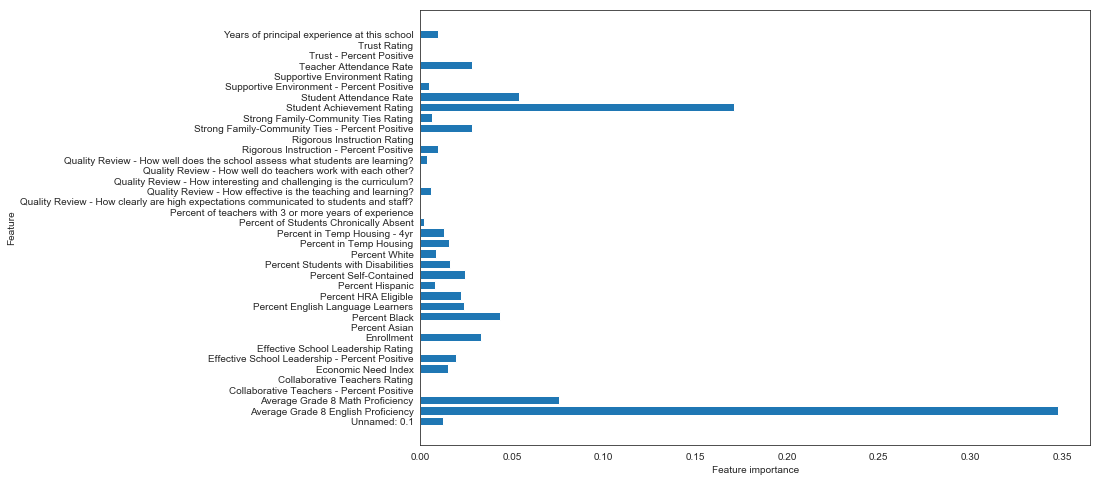

In [146]:
def plot_feature_importances(model, data_train, plot_name):
    n_features = data_train.shape[1]
    plt.figure(figsize=(12,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    file_path = 'plots/' + plot_name
    plt.savefig(file_path)

plot_feature_importances(clf, X_train, 'tree_features.png')

In [122]:
##
## Random Forest
##d
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)
print('train score: ', forest.score(X_train, y_train))
print('test score: ', forest.score(X_test, y_test))

train score:  0.9173469387755102
test score:  0.8489795918367347


In [123]:
y_pred = forest.predict(X_test)

In [124]:
print_acc_and_matrix(y_test, y_pred, label='Default Random Forest')

DEFAULT RANDOM FOREST


Accuracy is: 84.89795918367346

AUC is: 0.85
--------------------------------------------------
Confusion Matrix
col_0     0    1  All
target               
0        97   15  112
1        22  111  133
All     119  126  245
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       112
           1       0.88      0.83      0.86       133

    accuracy                           0.85       245
   macro avg       0.85      0.85      0.85       245
weighted avg       0.85      0.85      0.85       245



In [ ]:
##
## Random Forest was even better, so save it
##
joblib.dump(forest, 'random_forest.pkl')

In [148]:
len(features)

37

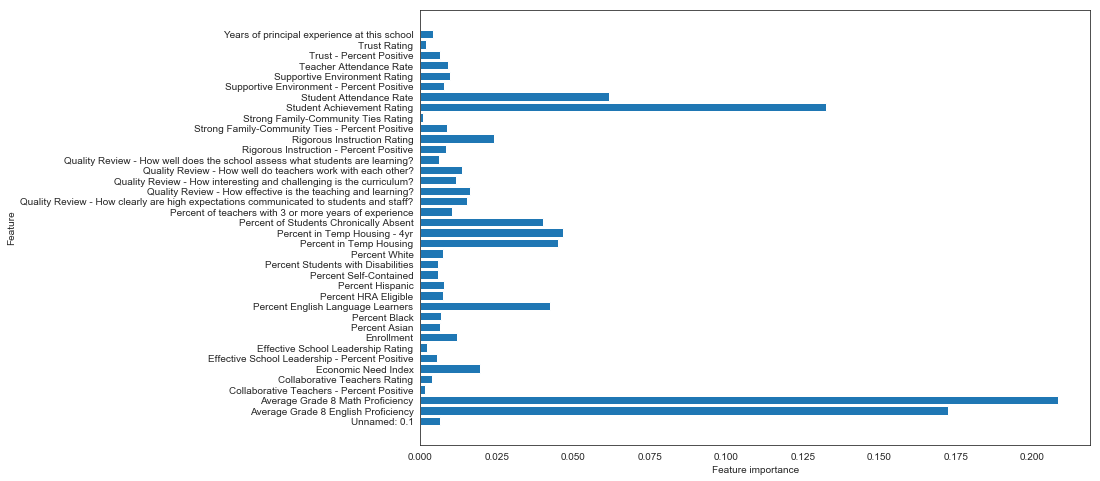

In [147]:
plot_feature_importances(forest, X_train, 'rf_features.png')

In [125]:
# {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
opt_forest = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_split=5)
opt_forest.fit(X_train, y_train)
print('train scoe: ', opt_forest.score(X_train, y_train))
print('test score: ', opt_forest.score(X_test, y_test))

train scoe:  0.9714285714285714
test score:  0.8244897959183674


In [126]:
y_pred = opt_forest.predict(X_test)

In [128]:
print_acc_and_matrix(y_test, y_pred, label='Optimized Random Forest')

OPTIMIZED RANDOM FOREST


Accuracy is: 82.44897959183673

AUC is: 0.82
--------------------------------------------------
Confusion Matrix
col_0     0    1  All
target               
0        93   19  112
1        24  109  133
All     117  128  245
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       112
           1       0.85      0.82      0.84       133

    accuracy                           0.82       245
   macro avg       0.82      0.82      0.82       245
weighted avg       0.83      0.82      0.82       245



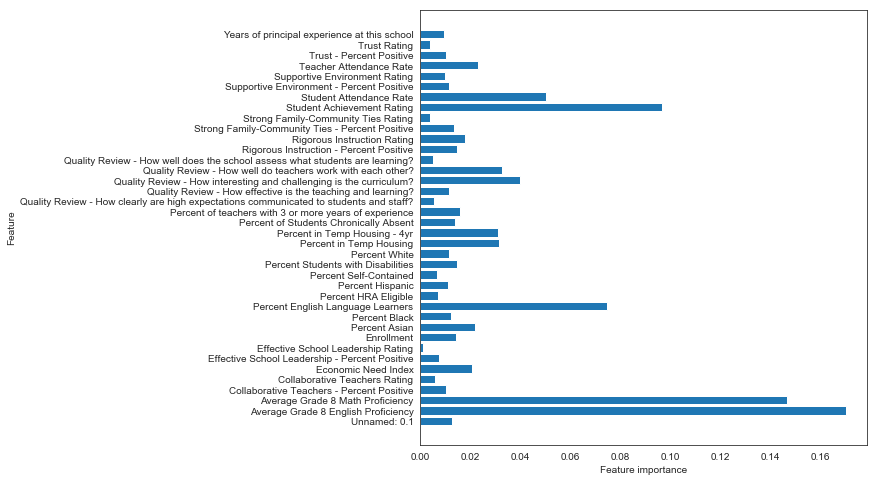

In [108]:
plot_feature_importances(opt_forest, X_train, 'opt_forest.png')

In [ ]:
forest_2 = RandomForestClassifier(n_estimators = 5, max_features= 10, max_depth= 2)
forest_2.fit(X_train, y_train)
rf_tree_1 = forest_2.estimators_[0]
#plot_feature_importances(rf_tree_1, X_train)

In [ ]:
rf_tree_2 = forest_2.estimators_[1]
plot_feature_importances(rf_tree_2, X_train)

In [ ]:
len(forest_2.estimators_)

In [ ]:
for i in range(len(forest_2.estimators_)):
    tree = forest_2.estimators_[i]
    tree_name = f'rf_tree_est_{i}.png'
    plot_feature_importances(tree, X_train, tree_name)

In [129]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [130]:
y_predict = knn.predict(X_test)

In [131]:
print_acc_and_matrix(y_test, y_predict, label='KNN')

KNN


Accuracy is: 59.183673469387756

AUC is: 0.59
--------------------------------------------------
Confusion Matrix
col_0     0    1  All
target               
0        64   48  112
1        52   81  133
All     116  129  245
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       112
           1       0.63      0.61      0.62       133

    accuracy                           0.59       245
   macro avg       0.59      0.59      0.59       245
weighted avg       0.59      0.59      0.59       245



In [ ]:
f1_score(y_test, y_predict, average='weighted')

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_predict, labels=None, sample_weight=None))
print(classification_report(y_test, y_pred))

In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10, 20]
}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

In [ ]:
gs_forest = GridSearchCV(forest, param_grid, cv=3)
gs_forest.fit(X_train, y_train)

gs_forest.best_params_

In [132]:
##
## XGBoost
##
XG_model = xgb.XGBClassifier()
XG_model.fit(X_train, y_train)
training_preds = XG_model.predict(X_train)
val_preds = XG_model.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))


Training Accuracy: 95.2%
Validation accuracy: 86.12%


In [133]:
print_acc_and_matrix(y_test, val_preds, label='XGBoost')

XGBOOST


Accuracy is: 86.12244897959184

AUC is: 0.86
--------------------------------------------------
Confusion Matrix
col_0     0    1  All
target               
0        98   14  112
1        20  113  133
All     118  127  245
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       112
           1       0.89      0.85      0.87       133

    accuracy                           0.86       245
   macro avg       0.86      0.86      0.86       245
weighted avg       0.86      0.86      0.86       245



In [ ]:
##
## Tune XGBoost
##
param_grid = {
    "learning_rate": [0.1],
    'max_depth': [6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

grid_clf = GridSearchCV(XG_model, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))


In [ ]:
# change kernel to "rbf"

In [134]:
##
## SVM Time
##
tic = time()
svclassifier = SVC(kernel='rbf')  
svclassifier.fit(X_train, y_train) 
y_pred = svclassifier.predict(X_test)
toc = time()
print("run time is {} seconds".format(toc-tic))

run time is 0.09510302543640137 seconds


In [ ]:
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

In [135]:
print_acc_and_matrix(y_test, y_pred, label='SVM-rbf-kernel')

SVM-RBF-KERNEL


Accuracy is: 46.93877551020408

AUC is: 0.5
--------------------------------------------------
Confusion Matrix
col_0     0   1  All
target              
0       101  11  112
1       119  14  133
All     220  25  245
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.90      0.61       112
           1       0.56      0.11      0.18       133

    accuracy                           0.47       245
   macro avg       0.51      0.50      0.39       245
weighted avg       0.51      0.47      0.37       245

